In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 1
%aimport plotter
%aimport simuling.analysis
%aimport

Concept list length: 400
Modules to reload:
plotter simuling.analysis

Modules to skip:



In [2]:
import matplotlib.pyplot as plt
import pandas
import numpy

In [3]:
def vocabulary_size(data, column="Cognateset_ID"):
    """Count different words in vocabulary."""
    return len(set(data[column]))

In [4]:
from simuling.analysis import semantic_width, synonymity, properties, default_properties

In [5]:
import json
all_clics = json.load(open("../original_data/summary"))
clics_vocabulary = all_clics["n"]
c_n = numpy.mean(clics_vocabulary)
clics_semantic_width = all_clics["p"]
c_p = numpy.mean(clics_semantic_width)
clics_synonymity = all_clics["s"]
c_s = numpy.mean(clics_synonymity)


In [6]:
from pathlib import Path
path = Path("../../runs")

Clics: 912.2±678.1
Simulation: nan±nan


/home/gereon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice.
/home/gereon/.local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gereon/.local/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/gereon/.local/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/gereon/.local/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


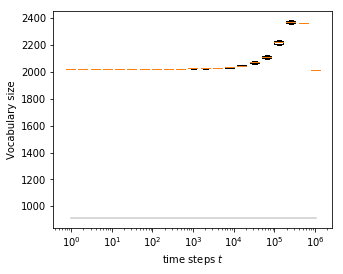

In [7]:
import os
n = {}
for file in path.glob("*.csv"):
    props = properties(file)
    if not props or "," in props["--tree"]:
        continue
    del props["--tree"], props["--branchlength"], props["--seed"]
    if all(props[key] == default_properties[key] for key in props):
        all_data = pandas.read_csv(
            file.open(),
            sep=",",
            na_values=[""],
            comment="#",
            keep_default_na=False,
            encoding='utf-8')

        for language_id, language_data in all_data.groupby("Language_ID"):
            n.setdefault(int(language_id), []).append(vocabulary_size(language_data))

plt.boxplot(list(n.values()), positions=list(n.keys()), widths=[i/2 for i in n.keys()], manage_xticks=False)

plt.plot([1, max(n)], [c_n, c_n], '0.8', label="Root #Words")

plt.xlabel("time steps $t$")
plt.gca().set_xscale('log')
plt.ylabel("Vocabulary size")
print("Clics: {:0.1f}±{:0.1f}".format(
    numpy.mean(clics_vocabulary), numpy.std(clics_vocabulary)))
stable = numpy.array(sum([n.get(2**i, []) for i in range(23, 27)], []))
print("Simulation: {:0.1f}±{:0.1f}".format(stable.mean(), stable.std()))
plt.gcf().set_size_inches(5,4)
plt.savefig("vocabularysize_timesteps.pdf")


In [8]:
max(n.keys()), n[max(n.keys())]

(1048576, [2013])

/home/gereon/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/gereon/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Synonymity
Simulation: -0.1±0.0
Polysemy
Simulation: 1.5±0.0


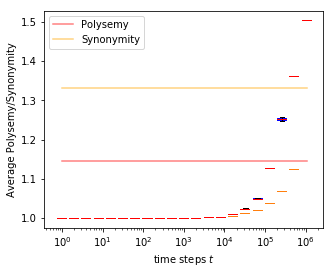

In [11]:
import os
s = {}
c = {}
p = {}
for file in path.glob("*.csv"):
    props = properties(file)
    if not props or "," in props["--tree"]:
        continue
    del props["--tree"], props["--branchlength"], props["--seed"]
    if all(props[key] == default_properties[key] for key in props):
        all_data = pandas.read_csv(
            file.open(),
            sep=",",
            na_values=[""],
            comment="#",
            keep_default_na=False,
            encoding='utf-8')

        for language_id, language_data in all_data.groupby("Language_ID"):
            s.setdefault(int(language_id), []).append(synonymity(language_data))
            
            sum_width = 0
            m = 0
            accs, widths = [], []
            for form, meanings in language_data.groupby("Cognateset_ID"):
                width = meanings["Weight"].sum()**2/(meanings["Weight"]**2).sum()
                accs.append(meanings["Weight"].sum())
                widths.append(width)
                sum_width += width
                m += 1
            c.setdefault(int(language_id), []).append(numpy.corrcoef(accs, widths)[1, 0])
            p.setdefault(int(language_id), []).append(sum_width/m)

plt.boxplot(list(n.values()), positions=list(s.keys()), widths=[i/2 for i in n.keys()], manage_xticks=False)
plt.boxplot(list(p.values()), positions=list(p.keys()), widths=[i/2 for i in p.keys()], manage_xticks=False,
               boxprops=dict(color='blue'), medianprops=dict(color='red'))

plt.plot([1, max(n)], [c_p, c_p], c='red', alpha=0.5, label="Polysemy")
plt.plot([1, max(n)], [c_s, c_s], c='orange', alpha=0.5, label="Synonymity")
plt.xlabel("time steps $t$")
plt.gca().set_xscale('log')
plt.ylabel("Average Polysemy/Synonymity")
plt.legend()
print("Synonymity")
#print("Clics: {:0.1f}±{:0.1f}".format(
#    numpy.mean(clics_synonymity), numpy.std(clics_synonymity)))
stable = numpy.array([v for k, v in c.items() if k>=2**20])
print("Simulation: {:0.1f}±{:0.1f}".format(stable.mean(), stable.std()))
print("Polysemy")
# print("Clics: {:0.1f}±{:0.1f}".format(
#    numpy.mean(clics_semantic_width), numpy.std(clics_semantic_width)))
stable = numpy.array([v for k, v in p.items() if k>=2**20])
print("Simulation: {:0.1f}±{:0.1f}".format(stable.mean(), stable.std()))
plt.gcf().set_size_inches(5,4)
plt.savefig("synonymitypolysemy_timesteps.pdf")


In [ ]:
plt.boxplot(list(c.values()), positions=list(c.keys()), widths=[i/2 for i in c.keys()], manage_xticks=False)

plt.xlabel("time steps $t$")
plt.gca().set_xscale('log')
plt.ylabel("Correlation between semantic width and accessibility")
plt.legend()

plt.gcf().set_size_inches(5,4)
plt.savefig("correlation_timesteps.pdf")
